In [37]:
!git clone https://github.com/Damowerko/ese2000-dynamical-systems.git
import sys

if sys.path[-1] != "./ese2000-dynamical-systems/":
    sys.path.append('./ese2000-dynamical-systems/')
print(sys.path[-2:])

fatal: destination path 'ese2000-dynamical-systems' already exists and is not an empty directory.
['/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/site-packages', './ese2000-dynamical-systems/']


In [38]:
from pathlib import Path
import matplotlib.style
import matplotlib.pyplot as plt
from collections import deque
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from IPython.core.display_functions import clear_output
from ese2000_dynamical.config import Config
from ese2000_dynamical.track import load_track, Track
from ese2000_dynamical.simulator import Simulator, dynamics_ca
import os


matplotlib.style.use("seaborn-v0_8-colorblind")
plt.rcParams["figure.dpi"] = 150

data_path = Path("./ese2000-dynamical-systems/data")
figure_path = Path("figures")

device = "cpu"

In [39]:
sim = Simulator()

In [40]:
# granularize trajectory for better comparison during training
# this recursively adds midpoints between every point by averaging consecutive points
def granularize(trajectory, amount):
    new_trajectory = []
    for i, point in enumerate(trajectory):
        average = (trajectory[(i + 1) % trajectory.shape[0]] + trajectory[i]) / 2
        new_trajectory.append(trajectory[i])
        new_trajectory.append(average)
    if amount == 1:
        return torch.stack(new_trajectory)
    return granularize(torch.stack(new_trajectory), amount - 1)

In [41]:
x_expert = np.load(data_path / "states.npy")
u_expert = np.load(data_path / "inputs.npy")
track = load_track(data_path / "track.npz")

chosen_expert_index = 5
original_timesteps = x_expert[chosen_expert_index].shape[0]
print("Original timesteps: ", original_timesteps)
x_sample = granularize(torch.tensor(x_expert[chosen_expert_index]).float().to(device),  2)
print(f"Granularized to {x_sample.shape[0]} timesteps")
max_timesteps = 250
a_sample = torch.tensor(u_expert[chosen_expert_index]).float().to(device)

A = torch.Tensor(sim.A).to(device)
B = torch.Tensor(sim.B).to(device)
state_scale = 20
action_scale = 35

Original timesteps:  200
Granularized to 800 timesteps


In [42]:
def plot_vs_expert(x, x_label: str, x_expert, track: Track):
    plt.figure()
    track.plot()
    plt.grid(True)
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.plot(x_expert[:, 0], x_expert[:, 1], "--", label="Expert")
    plt.plot(x[:, 0], x[:, 1], "-", label=x_label)
    plt.legend(loc="upper right", framealpha=1.0)

In [43]:
# Gets the closest point in the x_trajectory to a state
def get_closest_point(state, expert_trajectory=x_sample):
    if len(state.shape) == 1:
        state = state.unsqueeze(0)
    index = torch.argmin(torch.sqrt(torch.sum((expert_trajectory.unsqueeze(0) - state.unsqueeze(1)) ** 2, dim=-1)), dim=-1)
    closest_point = expert_trajectory[index]
    distance = torch.sqrt(torch.sum((closest_point- state) ** 2, dim=-1))
    return distance, closest_point, index

def reward_function(state, normalized_action):
    penalty_boundary = 1
    max_reward = 1.5
    action_magnitude_penalty = 0.075
    distance, _, _ = get_closest_point(state)
    if distance > penalty_boundary:
        return torch.tensor([-1]).to(device)
    return max_reward - distance - torch.sqrt(torch.sum(normalized_action) ** 2) * action_magnitude_penalty

In [44]:
# Buffer to keep track and sample previous trajectories during q_model training
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def __len__(self):
        return len(self.buffer)

    def push(self, normalized_look_ahead_state, normalized_actions, returns):
        experiences = torch.cat([normalized_look_ahead_state.detach(), normalized_actions.detach(), returns.detach()], dim=-1)
        for experience in experiences:
            self.buffer.append(experience)

    def sample(self, batch_size):
        batch = torch.stack(random.sample(self.buffer, batch_size))
        state_shape = (look_ahead_count + 1) * (state_dim)
        action_shape = action_dim
        normalized_look_ahead_states = batch[:, :state_shape]
        normalized_actions = batch[:, state_shape:state_shape+action_shape]
        rewards = batch[:, state_shape+action_shape:state_shape+action_shape+1]
        return normalized_look_ahead_states, normalized_actions, rewards

In [45]:
# Given a state, gets the closest `look_ahead_count` points to the state and creates a new state.
# At the end, all values are normalized by `state_scale`
all_indices = torch.arange(x_sample.shape[0] * 2).unsqueeze(0)
def get_state_with_look_ahead_normalized(state, look_ahead_count):
    if len(state.shape) == 1:
        state = state.unsqueeze(0)
    _, _, index = get_closest_point(state)
    if len(index.shape) == 0:
        index = index.unsqueeze(0)
    mask = all_indices.repeat(state.shape[0], 1)
    mask = (index.unsqueeze(-1) <= mask) & (mask < index.unsqueeze(-1) + look_ahead_count)
    look_ahead = x_sample.unsqueeze(0).repeat(state.shape[0], 2, 1)[mask]
    if len(look_ahead.shape) == 2:
        look_ahead = look_ahead.unsqueeze(0)
    look_ahead = look_ahead.reshape(state.shape[0], state_look_ahead_dim - 4)
    return torch.cat([state, look_ahead], dim=-1) / state_scale

# Iteratively calls model_policy to obtain actions and create a maximum length trajectory.
# Trajectory ends when it diverges `truncate_distance` from the true trajectory or trajectory is of `timesteps` size
def rollout(model_policy, truncate_distance, buffer, gamma, random_walk=False, no_truncate=False, random_start=True, max_timesteps=max_timesteps):
    # saves, at most, the last `save_count` states in the created trajectory to the replay buffer
    # for q_model training
    save_count = 25
    normalized_look_ahead_states = []
    predicted_trajectory = []
    normalized_actions = []
    rewards = []

    if random_start:
        state = x_sample[int(torch.rand(1).item() * x_sample.shape[0])]
    else:
        state = x_sample[0]
        
    for t in range(max_timesteps):
        normalized_look_ahead_state = get_state_with_look_ahead_normalized(state, look_ahead_count)
        normalized_look_ahead_states.append(normalized_look_ahead_state)
        if not random_walk:
            normalized_action = model_policy(normalized_look_ahead_state)
            action = normalized_action * action_scale
        else:
            normalized_action = torch.rand(action_dim)
            action = normalized_action * 2 * action_scale - action_scale
        normalized_actions.append(normalized_action)
        
        next_state = state.detach() @ A.T + action.detach() @ B.T
        predicted_trajectory.append(next_state)
        reward = reward_function(state, normalized_action)
        rewards.append(reward)
        if get_closest_point(state)[0] > truncate_distance and not no_truncate:
            break
        state = next_state
        
    predicted_trajectory = torch.stack(predicted_trajectory).squeeze(1)
    normalized_look_ahead_states = torch.stack(normalized_look_ahead_states).squeeze(1)
    normalized_actions = torch.stack(normalized_actions).squeeze(1)
    rewards = torch.stack(rewards)
    returns = get_returns(rewards, gamma)
    min_items  = min(normalized_look_ahead_states.shape[0], save_count)
    buffer.push(normalized_look_ahead_states[-1 * min_items:], normalized_actions[-1 * min_items:], returns[-1 * min_items:])
    
    return predicted_trajectory, normalized_actions, rewards, returns

In [46]:
look_ahead_count = 10
state_dim = 4
action_dim = 2
state_look_ahead_dim = state_dim * (look_ahead_count + 1)
class QHat(nn.Module):
    def __init__(self):
        super(QHat, self).__init__()
        self.fc1 = nn.Linear(state_look_ahead_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
    
    def forward(self, normalized_state_look_ahead, normalized_action):
        x = torch.cat([normalized_state_look_ahead, normalized_action], dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q = self.fc4(x)
        return q

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_look_ahead_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 2)
        init.uniform_(self.fc4.weight, a=-1e-6, b=1e-6)

    def forward(self, normalized_state_look_ahead):
        x = normalized_state_look_ahead
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        return x

In [47]:
def get_returns(rewards, gamma):
    returns = []
    for i in range(rewards.shape[0]):
        returns.append(rewards[i] + gamma * rewards[i + 1:].sum())
    return torch.stack(returns)
    

In [53]:
if os.path.exists("./models/q_model.pth") and os.path.exists("./models/policy_model.pth"):
    Q  = torch.load("./models/q_model.pth").to(device)
    policy  = torch.load("./models/policy_model.pth").to(device)
    print("Model already trained and loaded from file 'models/model.pth'")
    print("If you would like to retrain your model, delete './models' and run this cell again.")
else:
    Q = QHat().to(device)
    policy = Policy().to(device)

Model already trained and loaded from file 'models/model.pth'
If you would like to retrain your model, delete './models' and run this cell again.


In [54]:
Q_opt = torch.optim.Adam(Q.parameters(), lr=1e-4)
policy_opt = torch.optim.Adam(policy.parameters(), lr=2e-5, maximize=True)

Epoch 1	 Episode 5001	 Mean return: 0.5158427953720093	 Est. return: -0.7324620485305786	 Q. Loss: 0.40439510345458984 Trajectory size: 4


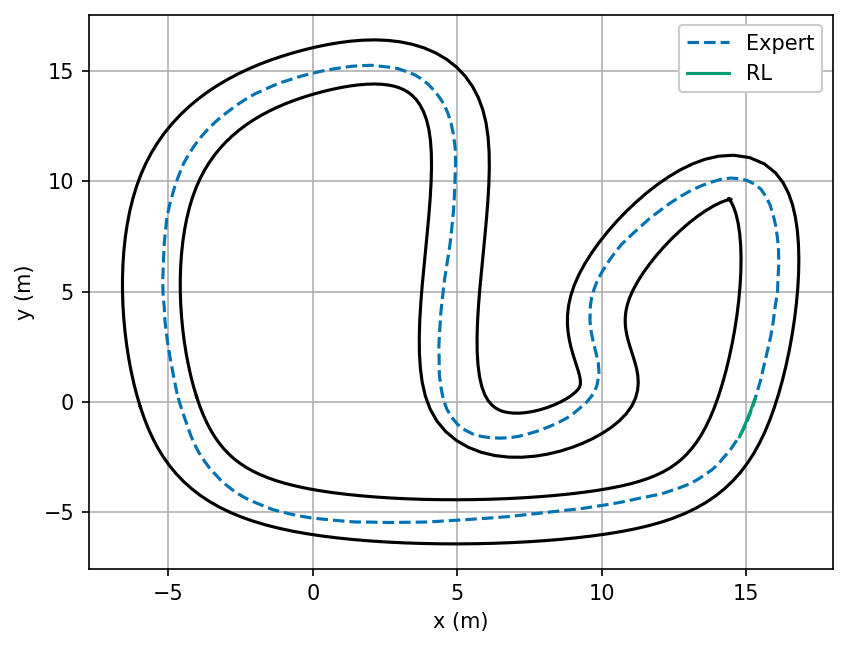

 10%|█         | 5123/50000 [00:22<03:17, 227.23it/s]


KeyboardInterrupt: 

In [55]:
from tqdm import trange

torch.set_printoptions(precision=3)
episodes = 50_000
gamma = 0.99
q_train_iterations = 3
policy_train_iterations = 1
compute_Q_loss = nn.MSELoss()
truncate_distance = 1
q_batch_size = 256
buffer = ReplayBuffer(100_000)
random_walk_epochs = 2500
policy_loss = 0
Q_loss = 0
epochs = 2

if not os.path.exists("./models/q_model.pth") and not os.path.exists("./models/policy_model.pth"):
    for epoch in range(epochs):
        buffer = ReplayBuffer(100_000)
        for episode in trange(episodes):
            Q.train()
            policy.eval()
            with torch.no_grad():
                if episode < random_walk_epochs:
                    states, actions, rewards, returns = rollout(policy, truncate_distance, buffer, gamma, True)
                else:
                    states, actions, rewards, returns = rollout(policy, truncate_distance, buffer, gamma, False)
            if q_batch_size <= len(buffer):
                for i in range(q_train_iterations):
                    Q_opt.zero_grad()
                    batch_sample_states, batch_sample_actions, batch_sample_returns = buffer.sample(q_batch_size)
                    Q_hat = Q(batch_sample_states, batch_sample_actions)
                    
                    Q_loss = compute_Q_loss(batch_sample_returns, Q_hat)
                    Q_loss.backward()
                    
                    Q_opt.step()
            
            if episode > random_walk_epochs:
                Q.eval()
                policy.train()
                
                states, actions, rewards, returns = rollout(policy, truncate_distance, buffer, gamma, False)
                for i in range(policy_train_iterations):
                    policy_opt.zero_grad()
                
                    normalized_states = get_state_with_look_ahead_normalized(states, look_ahead_count)
                    normalized_actions = policy(normalized_states)
            
                    Q_hat = Q(normalized_states, normalized_actions)
                    policy_loss = torch.mean(Q_hat)
                    policy_loss.backward()
            
                    policy_opt.step()
            mean_reward = torch.mean(rewards)
        
            if episode % 1000 == 0:
                clear_output()
                print(f'Epoch {epoch+1}\t Episode {episode+1}\t Mean return: {mean_reward}\t Est. return: {policy_loss}\t Q. Loss: {Q_loss} '
                      f'Trajectory size: {states.shape[0]}')
                plot_vs_expert(states.detach().cpu().numpy(), 'RL', x_sample.detach().cpu().numpy() , track)
                plt.show()
                
    Path('./models').mkdir(exist_ok=True)
    torch.save(Q, "./models/q_model.pth")
    torch.save(policy, "./models/policy_model.pth")

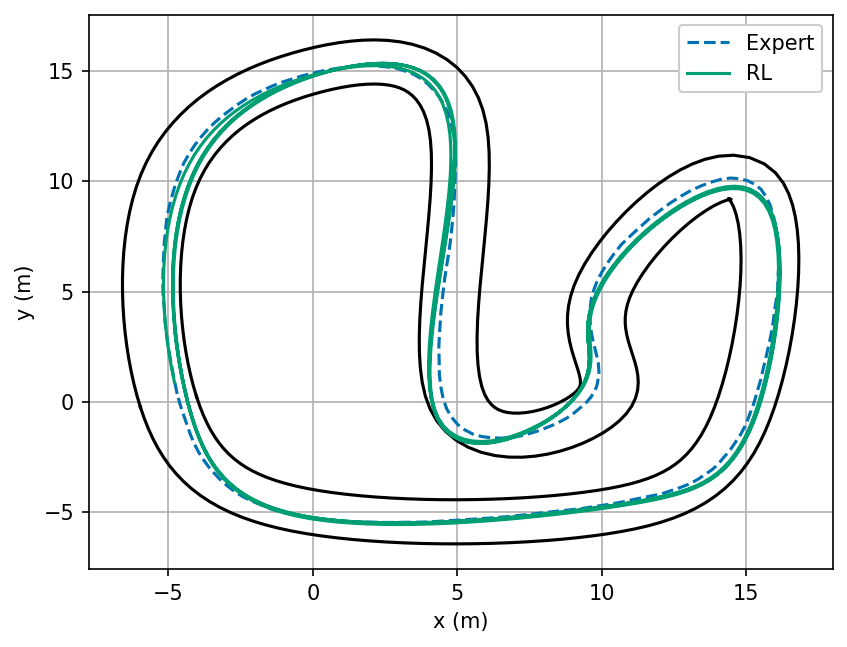

Mean Reward:  1.0106494426727295


In [19]:
policy.eval()
states, actions, rewards, returns = rollout(policy, truncate_distance, buffer, gamma, False, True, False, 800)
plot_vs_expert(states.detach().cpu().numpy(), 'RL', x_sample.detach().cpu().numpy() , track)
plt.show()
print("Mean Reward: ", torch.mean(rewards).item())